# Generating the Mercator grid

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# Mercator projectione 


For a given $(longitude,latitude) = (\lambda, \phi)$ the isotropic Mercator projection can be written as:  
$$\begin{equation}
y = M(\phi) = R \ln \left[ 1+\sin\phi \over \cos\phi \right].  
\end{equation}$$
The corresponding inverse function can be written as:
$$\begin{equation}
\phi = M^{-1}(y) = \tan^{-1}\left(\sinh(y/R)\right).
\end{equation}$$

Here $R$ is the radius of the "globe" representing the Earth and is determined by the scale of the projection. E.g., to project the earth surface to a rectangular map of width $L$ one can use a principal scale of $L/(2\pi a_{E})$ (radius of the isotropic Earth), which corresponds to a "globe" of radius $R=L/2\pi$ .Note that  this function does not describe the geometrical projection (as of light rays onto a screen) from the centre of the globe to the cylinder, which is only one of an unlimited number of ways to conceptually project a cylindrical map.

These are one of a few equivalent analytic forms of the projection function. For an overview and more information refer to [https://en.wikipedia.org/wiki/Mercator_projection](the wikipedia).


# Defining a Mercator grid


We want to generate an isotropic Mercator grid corresponding to a 1/4 degree resolution at the equator. Here are the defining parameters of our super-grid:

 
1. The (super)grid cell resolution in longitude direction $\Delta \lambda = {1/8}^\circ $.  
2. The (super)grid cell resolution in latitude  direction shall be the same as in longitude direction at the equator $\Delta \phi(\phi=0) = \Delta \lambda$. 

So:
  
1. To achieve 1. above we partition the equator to $N_i$ intervals. The condition 1. above fixes $N_i=2880$ , since  $\Delta \lambda = (1/8)(\pi/180) = {2\pi\over N_i}$.
2. To achieve 2. above we need to calculate $\Delta y$ given $\Delta \phi$:
$$\begin{equation*}
\Delta \phi = \Delta y \left. ({d\phi \over dy}) \right|_{y=0} = \Delta y {1\over R} {\cosh(y/R) \over 1+\sinh^2(y/R)} |_{y=0} = {\Delta y \over R}
\end{equation*}$$

Now 1. and 2. fix the value of the projection scale $R$ as follows:
$$\begin{equation}
R = {\Delta y \over \Delta \phi}|_{y=0} = {\Delta y \over \Delta \lambda}|_{y=0} = {1 \over (\delta \lambda /N_i)} = {N_i \over 2\pi}
\end{equation}$$


Note that we treat $y$ as an index in the latitude direction $\Delta y = \Delta j =1 $!


## Specification via approximate latitude bounds

If we are given $N_i$, $\tilde{\Phi}_s$, $\tilde{\Phi}_n$ then:
\begin{align}
R &= \frac{N_i}{2\pi} \\
y_s &= {int} (\tilde{\Phi}_s) \\
y_n &= {int} (\tilde{\Phi}_n)
\end{align}
and
\begin{align}
\Phi_s &= \Phi(y_s) \\
\Phi_n &= \Phi(y_n)
\end{align}
where $\Phi_s \neq \tilde{\Phi}_s$ and $\Phi_n \neq \tilde{\Phi}_n$

#### How should $\tilde{\Phi}_s$ and $\tilde{\Phi}_n$ be specified?

## Implementation

### helper routines and constants

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

#Constants
PI_180 = np.pi/180.
_default_Re = 6.378e6

#utility function to plot grids
def plot_mesh_in_latlon(lam, phi, stride=1, phi_color='k', lam_color='r'):
    if (phi.shape != lam.shape): raise Exception('Ooops: lam and phi should have same shape')
    nj,ni = lam.shape
    for i in range(0,ni,stride):
        plt.plot(lam[:,i],phi[:,i],lam_color)
    for j in range(0,nj,stride):
        plt.plot(lam[j,:],phi[j,:],phi_color)
#plot_mesh_in_latlon(lams,phis,stride=16)

def restrict(lam,phi,lowerlat):
    nj,ni = lam.shape
    for j in range(0,nj):
        if(phi[j,0]>lowerlat):
            break
    jmin=j
    print("jmin",jmin)
    return lam[jmin:,:], phi[jmin:,:]

def plot_mesh_in_xyz(lam, phi, stride=1, phi_color='k', lam_color='r', lowerlat=None):
    if lowerlat is not None:
        lam,phi = restrict(lam,phi,lowerlat)
    x = np.cos(phi*PI_180) * np.cos(lam*PI_180)
    y = np.cos(phi*PI_180) * np.sin(lam*PI_180)
    z = np.sin(phi*PI_180)
        
    plot_mesh_in_latlon(x, y, stride=stride, phi_color=phi_color, lam_color=lam_color)
#plt.figure(figsize=(6,6))
#plot_mesh_in_xyz(lams, phis, stride=20)

def mdist(x1,x2):
  """Returns positive distance modulo 360."""
  a=np.mod(x1-x2+720.,360.)
  b=np.mod(x2-x1+720.,360.)
  d=np.minimum(a,b)
  return d

def generate_grid_metrics(x,y,axis_units='degrees',Re=_default_Re,latlon_areafix=False):
    nytot,nxtot = x.shape
    if  axis_units == 'm':
      metric=1.0
    if  axis_units == 'km':            
      metric=1.e3
    if  axis_units == 'degrees':                        
      metric=Re*PI_180
    ymid_j = 0.5*(y+np.roll(y,shift=-1,axis=0))
    ymid_i = 0.5*(y+np.roll(y,shift=-1,axis=1))      
    dy_j = np.roll(y,shift=-1,axis=0) - y
    dy_i = np.roll(y,shift=-1,axis=1) - y
    dx_i = mdist(np.roll(x,shift=-1,axis=1),x)
    dx_j = mdist(np.roll(x,shift=-1,axis=0),x)
    dx = metric*metric*(dy_i*dy_i + dx_i*dx_i*np.cos(ymid_i*PI_180)*np.cos(ymid_i*PI_180))
    dx = np.sqrt(dx)
    dy = metric*metric*(dy_j*dy_j + dx_j*dx_j*np.cos(ymid_j*PI_180)*np.cos(ymid_j*PI_180))
    dy = np.sqrt(dy)
    dx=dx[:,:-1]
    dy=dy[:-1,:]
    if(latlon_areafix):
        delsin_j = np.roll(np.sin(y*PI_180),shift=-1,axis=0) - np.sin(y*PI_180)
        area=metric*metric*dx_i[:-1,:-1]*delsin_j[:-1,:-1]/PI_180
    else:
        area=dx[:-1,:]*dy[:,:-1]    

    angle_dx=np.zeros((nytot,nxtot))
#    angle_dx = np.arctan2(dy_i,dx_i)/PI_180      
#    self.angle_dx = numpy.arctan2(dy_i,dx_i)*180.0/numpy.pi
    # The commented out code above was incorrect for non-Cartesian grids
    # The corrected version, in addition to including spherical metrics, is centered in the interior and one-sided at the grid edges
    angle_dx[:,1:-1] = np.arctan2(y[:,2:]-y[:,:-2],(x[:,2:]-x[:,:-2])*np.cos(y[:,1:-1]*PI_180))
    angle_dx[:,0]    = np.arctan2(y[:,1] -y[:,0]  ,(x[:,1] -x[:,0]  )*np.cos(y[:,0]*PI_180))
    angle_dx[:,-1]   = np.arctan2(y[:,-1]-y[:,-2] ,(x[:,-1]-x[:,-2] )*np.cos(y[:,-1]*PI_180))
    angle_dx = angle_dx /PI_180
    
    return dx,dy,area,angle_dx


def write_nc(x,y,dx,dy,area,angle,axis_units='degrees',fnam=None,format='NETCDF3_CLASSIC'):
    import netCDF4 as nc

    if fnam is None:
      fnam='supergrid.nc'
    f=nc.Dataset(fnam,'w',format=format)
    dims=[]
    vars=[]
    nytot,nxtot = y.shape
    nyp=f.createDimension('nyp',nytot)
    nxp=f.createDimension('nxp',nxtot)
    ny=f.createDimension('ny',nytot-1)
    nx=f.createDimension('nx',nxtot-1)    
    yv=f.createVariable('y','f8',('nyp','nxp'))
    xv=f.createVariable('x','f8',('nyp','nxp'))    
    yv.units=axis_units
    xv.units=axis_units 
    yv[:]=y
    xv[:]=x
    dyv=f.createVariable('dy','f8',('ny','nxp'))
    dyv.units='meters'
    dyv[:]=dy
    dxv=f.createVariable('dx','f8',('nyp','nx'))
    dxv.units='meters'
    dxv[:]=dx
    areav=f.createVariable('area','f8',('ny','nx'))
    areav.units='m2'
    areav[:]=area
    anglev=f.createVariable('angle_dx','f8',('nyp','nxp'))
    anglev.units='degrees'
    anglev[:]=angle            
    f.sync()
    f.close()

def generate_latlon_grid(lni,lnj,llon0,llen_lon,llat0,llen_lat):
    llonSP = llon0 + np.arange(lni+1) * llen_lon/lni
    llatSP = llat0 + np.arange(lnj+1) * llen_lat/lnj
    llamSP = np.tile(llonSP,(lnj+1,1)) 
    lphiSP = np.tile(llatSP.reshape((lnj+1,1)),(1,lni+1)) 
    return llamSP,lphiSP


### grid parameters

In [2]:
# Specify the grid properties
# All
# Specify the desired resolution
degree_resolution_inverse = 4 #quarter degree grid
refine=2    # Set to 2 for supergrid
lenlon=360  # global longitude range
lon0=-300.  # Starting longitude (longitude of the Northern bipoles)
Ni = lenlon*refine*degree_resolution_inverse

#Mercator grid
phi_s_Merc, phi_n_Merc = -66.85954724706843, 64.0589597296948

#Southern grid
Nj_SO=110*refine
lat0_SO=-78.0
lenlat_SO = phi_s_Merc-lat0_SO 

#Southern cap
Nj_scap=80*refine
lon_dp=100.0   # longitude of the displaced pole 
r_dp=0.20
doughnut=0.12

#Northern bipolar cap
Nj_ncap=119*refine
lon_bp=lon0 # longitude of the displaced pole(s)
lat0_bp=phi_n_Merc #61.247692871618455 #mercator.y.max()
lenlat_bp=90.0-lat0_bp


### Implementation of the algorithm

y*= [-727  673] nj= 1400
Actual phi range: phi_s,phi_n= [-66.85954725  64.05895973]
Grid = [-66.85954725 -66.81037464 -66.76110332 ...  63.94938346  64.00422531
  64.05895973]
jmin 979


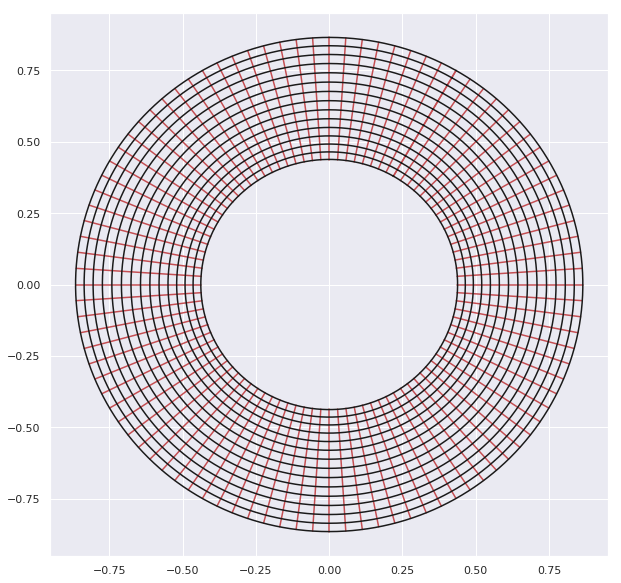

In [11]:
def y_mercator(Ni, phi):
    """Equation (1)"""
    R = Ni / (2 * np.pi)
    return R * ( np.log( (1.0 + np.sin(phi) ) / np.cos(phi)) )
def phi_mercator(Ni, y):
    """Equation (2)"""
    R = Ni / (2 * np.pi)
    return np.arctan( np.sinh(y/R) ) * (180/np.pi) # Converted to degrees
def y_mercator_rounded(Ni, phi):
    y_float = y_mercator(Ni, phi)
    return ( np.sign(y_float) * np.ceil( np.abs(y_float) ) ).astype(int)

def generate_mercator_grid(Ni,phi_s,phi_n,lon0_M,lenlon_M):
    # Diagnose nearest integer y(phi range)
    y_star = y_mercator_rounded(Ni, np.array([phi_s*PI_180,phi_n*PI_180]))
    Nj=y_star[1]-y_star[0]
    print( 'y*=',y_star, 'nj=', Nj )
    print( 'Actual phi range: phi_s,phi_n=', phi_mercator(Ni, y_star) )
    phi_M = phi_mercator(Ni, np.arange(y_star[0],y_star[1]+1)) 
    print( 'Grid =', phi_M )
#    if(y_star[1]-y_star[0] != Nj):
#        print("Error: the Mercator construct did not produce the expected number of j points ",Nj)
    y_grid_M = np.tile(phi_M.reshape(Nj+1,1),(1,Ni+1))
    lam_M = lon0_M + np.arange(Ni+1) * lenlon_M/Ni
    x_grid_M = np.tile(lam_M,(Nj+1,1)) 
    return x_grid_M,y_grid_M
    

#generate the grid
lamMerc,phiMerc = generate_mercator_grid(Ni,phi_s_Merc,phi_n_Merc,lon0,lenlon)    
#### Why N_j comes out of the above but is needed as an input to MIDAS?

#generate the metrics
dxMerc,dyMerc,areaMerc,angleMerc = generate_grid_metrics(lamMerc,phiMerc,axis_units='degrees',Re=1, latlon_areafix=True)

#write the grid file
#write_nc(lamMerc,phiMerc,dxMerc,dyMerc,areaMerc,angleMerc,axis_units='degrees',fnam='mercator_new.nc')

#plot grid
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lamMerc,phiMerc, stride=30,lowerlat=30)

In [12]:
def metrics_error(dx_,dy_,area_,lat1,lat2=90,Re=_default_Re):
    exact_area = 2*np.pi*(Re**2)*(np.sin(lat2*PI_180)-np.sin(lat1*PI_180))
    exact_lat_arc_length = (lat2-lat1)*PI_180*Re  
    exact_lon_arc_length = np.cos(lat1*PI_180) *2*np.pi*Re

    if(lat2 == -90):
        grid_lat_arc_length = (np.sum(dy_[:,0])+np.sum(dy_[:,Ni//2]))/2
        grid_lon_arc_length = np.sum(dx_[-1,:])
    else:
        grid_lat_arc_length = np.sum(dy_[:,Ni//4])
        grid_lon_arc_length = np.sum(dx_[0,:])
        
    area_error = 100*(np.sum(area_)-exact_area)/exact_area
    lat_arc_error = 100*(grid_lat_arc_length - exact_lat_arc_length)/exact_lat_arc_length
    lon_arc_error = 100*(grid_lon_arc_length -  exact_lon_arc_length)/exact_lon_arc_length
    
    return area_error,lat_arc_error,lon_arc_error


#generate the metrics
print("%NEW   errors in (area,lat arc,lon arc)", metrics_error(dxMerc,  dyMerc,  areaMerc, lat1=phi_s_Merc, lat2=phi_n_Merc,Re=1))


%NEW   errors in (area,lat arc,lon arc) (4.663256399271965e-14, 0.0, -1.7985096952495446e-14)


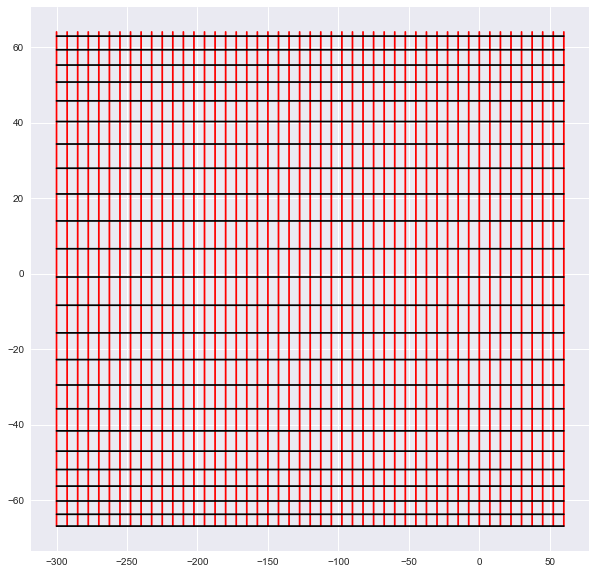

In [5]:
plt.figure(figsize=(10,10))
plot_mesh_in_latlon(lamMerc,phiMerc, stride=60)

# Generating a Mercator grid via package MIDAS

The code snippet below uses the MIDAS package to generate the Mercator grid. We first want to study the calls in this package to find out how MIDAS has been generating the grids. Note that this "import"s a class that was isolated from original MIDAS, hence we call it "pymidas" to distinguish it from the whole package. This is a small fraction of MIDAS and is pure Python.

Note: I am generating this notebook with anaconda Python 3 on my workstation. 

First let's take a look at the grid generated straight from pymidas for a given longitude (since the grid is homogeneous in x direction).

In [6]:
lat0_Merc=-65.0  # This is a nominal starting latitude for Mercator grid
lenlat_Merc=125  # nominal latitude range of Mercator grid
Nj_Merc=700*refine
# Specify approximate latitude range
#phi_s, phi_n = lat0_M,lat0_M+lenlat_M
# To reproduce MIDAS we need to change these to the values produced by MIDAS 

from pymidas.rectgrid_gen import supergrid
#### Begin Mercator Grid
print ('constructing a mercator supergrid with (ni,nj) = ',Ni,Nj_Merc)
print ('nominal starting lat and starting longitude =',lat0_Merc, lon0)
print ('and nominal width in latitude = ',lenlat_Merc)
mercator=supergrid(nxtot=Ni,xstart=lon0,lenx=lenlon,
                   nytot=Nj_Merc,ystart=lat0_Merc,leny=lenlat_Merc,
                   config='mercator',axis_units='degrees',cyclic_x=True)
mercator.grid_metrics()
mercator.write_nc('mercator_supergrid.nc')
print ("mercator start/end latitudes=",mercator.y[0,0],mercator.y[-1,0])
print ("mercator start/end longitude=",mercator.x[0,0],mercator.x[0,-1])

constructing a mercator supergrid with (ni,nj) =  2880 1400
nominal starting lat and starting longitude = -65.0 -300.0
and nominal width in latitude =  125
mercator start/end latitudes= -66.85954724706843 64.0589597296948
mercator start/end longitude= -300.0 60.0


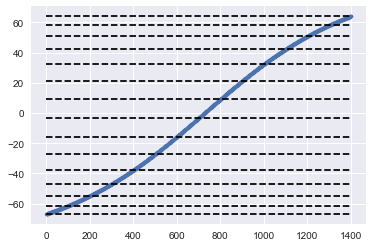

In [7]:
plt.plot( mercator.y[:,0], '.');
for j in np.arange(0,Nj_Merc+1,100):
    plt.plot([0,1400],[mercator.y[j,0],mercator.y[j,0]],linestyle='dashed',color='black')

## MIDAS Algorithm

Mercator projection scale used by MIDAS  458.3662361046586


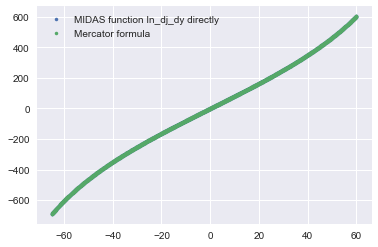

In [8]:
int_dj_dy_=np.zeros(Nj_Merc+1)
geo_lat=np.zeros(Nj_Merc+1)
merc_lat=np.zeros(Nj_Merc+1)
Intdjdy=np.zeros(Nj_Merc+1)

IC0 = Ni/lenlon/PI_180 #This is nx/2pi for global grid

R = IC0 #Mercator projection scale
print("Mercator projection scale used by MIDAS ",R)
for j in np.arange(Nj_Merc+1):
    y = lat0_Merc*PI_180 + j* PI_180 * lenlat_Merc/Nj_Merc
    #This is the formula for the function Int_dj_dy used in MIDAS/rectgrid_gen.py
    #There is no need for splitting the function in two pieces depending on sgn(y) as is done in MIDAS!
#    if(y >= 0.0):
#        int_dj_dy_[j]= R*(np.log((1.0+np.sin(y))/np.cos(y)))
#    else:
#        int_dj_dy_[j]=-R*(np.log((1.0-np.sin(y))/np.cos(y)))

    #This is calling the MIDAS function Int_dj_dy directly
    Intdjdy[j]=mercator.Int_dj_dy(y) 
    
    #The following is the formula for Mercator projection equation(1)
    #where R is the scale factor of the projection 
    merc_lat[j]=R*(np.log((1.0+np.sin(y))/np.cos(y))) 
    geo_lat[j] = y / PI_180

plt.plot(geo_lat,Intdjdy,    '.',label="MIDAS function In_dj_dy directly")        
#plt.plot(geo_lat,int_dj_dy_, '.',label="MIDAS function In_dj_dy copied")        
plt.plot(geo_lat,merc_lat,   '.',label="Mercator formula")        
plt.legend(loc=0)

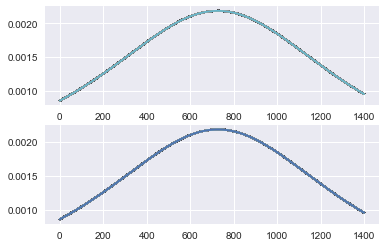

In [9]:
dxMerc1,dyMerc1,areaMerc1,angleMerc1 = generate_grid_metrics(lamMerc,phiMerc,axis_units='degrees',Re=1)
plt.subplot(2, 1, 1)
plt.plot(dxMerc1);
plt.subplot(2, 1, 2)
plt.plot(dyMerc1);


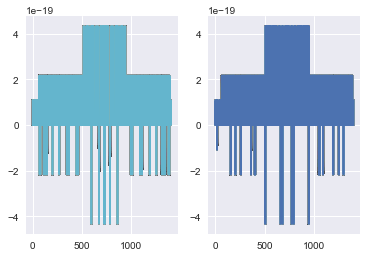

In [14]:
def generate_grid_metrics_latlon(x,y,Re=_default_Re):
    R = Ni / (2 * np.pi)
    hlon_inv = Re*np.cos(y*PI_180)
    hlat_inv = Re     
    dx = mdist(np.roll(x,shift=-1,axis=1),x)
    dy = np.roll(y,shift=-1,axis=0)-y
    dx=PI_180*dx*hlon_inv
    dy=PI_180*dy*hlat_inv
    #delete the last element (undetermined)
    #print(dx.shape)(221, 2881)
    dx=dx[:,:-1]
    dy=dy[:-1,:]
    #print(dx.shape)(221, 2880)
    
    return dx,dy

#because of the backward step in generating the grid hlat is the same as for a latlon grid 
dx1,dy1 = generate_grid_metrics_latlon(lamMerc,phiMerc,Re=1)

plt.subplot(1, 2, 1)
plt.plot(dx1-dxMerc1);
plt.subplot(1, 2, 2)
plt.plot(dy1-dyMerc1);
